# Import Packages

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Load Data

In [3]:
pump_failure_data = pd.read_csv("data/hypothetical_pump_failure_dataset.csv")
pump_failure_data['timestamp'] = pd.to_datetime(pump_failure_data['timestamp'])

In [4]:
pump_failure_data.head()

,timestamp,vibration_level,temperature_C,pressure_PSI,flow_rate_m3h,failure
0,2024-01-01 00:00:00,0.549671,76.996777,93.248217,40.460962,0
1,2024-01-01 01:00:00,0.486174,74.623168,98.554813,45.698075,0
2,2024-01-01 02:00:00,0.564769,70.298152,92.075801,47.931972,0
3,2024-01-01 03:00:00,0.652303,66.765316,96.920385,59.438438,0
4,2024-01-01 04:00:00,0.476585,73.491117,81.063853,52.782766,0


# Scale the Features

In [5]:
scaler = StandardScaler()
features = pump_failure_data.drop(['failure', 'timestamp'], axis=1)
scaled_features = scaler.fit_transform(features)

# Concatenate timestamp feature with scaled features

In [6]:
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['timestamp'] = pump_failure_data['timestamp']
scaled_df['failure'] = pump_failure_data['failure'].values

In [7]:
# Sort by timestamp to maintain the temporal sequence
scaled_df.sort_values(by='timestamp', inplace=True)

# Prepare X and y

In [8]:
X = scaled_df.drop(['failure', 'timestamp'], axis=1)
y = scaled_df['failure']

In [9]:
# Reshape X for LSTM
X = np.array(X).reshape((X.shape[0], 1, X.shape[1]))

# Train Test Split

In [10]:
train_size = int(len(scaled_df) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Develop Forecasting Model

In [20]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [35]:
optimizer = SGD(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
100/100 - 10s - loss: 0.0553 - accuracy: 0.9812 - val_loss: 0.0917 - val_accuracy: 0.9700 - 10s/epoch - 103ms/step
Epoch 2/50
100/100 - 1s - loss: 0.0471 - accuracy: 0.9850 - val_loss: 0.0901 - val_accuracy: 0.9700 - 701ms/epoch - 7ms/step
Epoch 3/50
100/100 - 1s - loss: 0.0534 - accuracy: 0.9812 - val_loss: 0.0899 - val_accuracy: 0.9700 - 782ms/epoch - 8ms/step
Epoch 4/50
100/100 - 1s - loss: 0.0497 - accuracy: 0.9812 - val_loss: 0.0891 - val_accuracy: 0.9700 - 784ms/epoch - 8ms/step
Epoch 5/50
100/100 - 1s - loss: 0.0441 - accuracy: 0.9850 - val_loss: 0.0886 - val_accuracy: 0.9700 - 793ms/epoch - 8ms/step
Epoch 6/50
100/100 - 1s - loss: 0.0524 - accuracy: 0.9787 - val_loss: 0.0864 - val_accuracy: 0.9700 - 778ms/epoch - 8ms/step
Epoch 7/50
100/100 - 1s - loss: 0.0454 - accuracy: 0.9825 - val_loss: 0.0872 - val_accuracy: 0.9700 - 781ms/epoch - 8ms/step
Epoch 8/50
100/100 - 1s - loss: 0.0617 - accuracy: 0.9787 - val_loss: 0.0870 - val_accuracy: 0.9700 - 784ms/epoch - 8ms/step

# Predict Test Data

In [37]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

7/7 [==============================] - 2s 6ms/step


In [38]:
print("LSTM Classification Report:")
print(classification_report(y_test, y_pred))

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       190
           1       0.83      0.50      0.62        10

    accuracy                           0.97       200
   macro avg       0.90      0.75      0.80       200
weighted avg       0.97      0.97      0.97       200



In [39]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[189   1]
 [  5   5]]


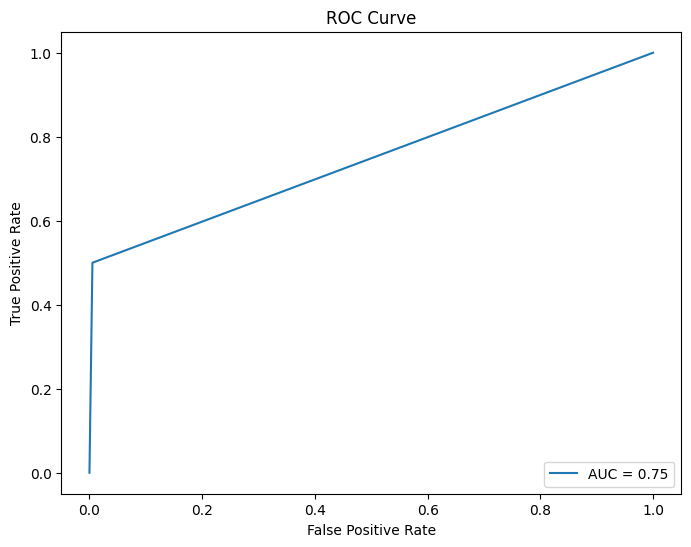

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()